# Issue frequency notebook

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load imports.py
# Basic imports
import os
import sys

import matplotlib

sys.path.append('./')

# SQL database
import pymysql

# Classical external libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('classic')

import seaborn as sns
sns.set(style="darkgrid")

import typing
from datetime import date

In [14]:
from visualization import plot_issues_time_id, catplot_by_batch_np, catplot_by_batch_np2
from sql import db_engine, read_table
from helpers import group_and_count, decade_from_year_df

In [4]:
%matplotlib inline

## Connection to DB & load useful data

In [5]:
# Connexion database
engine = db_engine()

In [6]:
#newspapers_df = read_table('impresso.newspapers', engine)
issues_df = read_table('impresso.issues', engine)

## Number of newspaper issues by year/decade, filtered by provenance / language

In [7]:
EARLIEST = 1740
LATEST = 2019

#### Switzerland

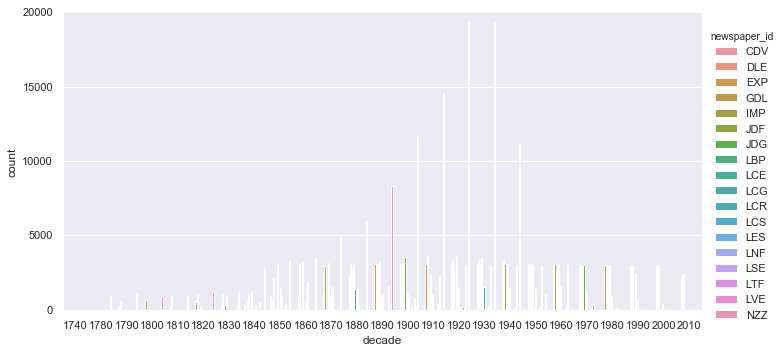

In [8]:
# Note : might take some time because we create the column 'decade'
plot_issues_time_id('decade', EARLIEST, LATEST, df = issues_df, country='CH')

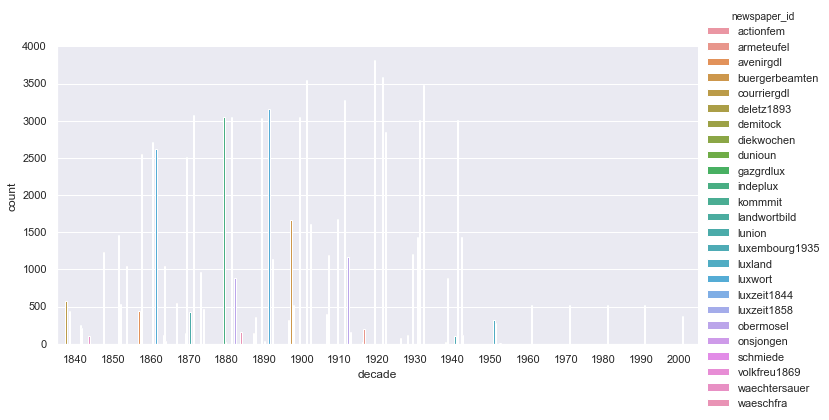

In [11]:
plot_issues_time_id('decade', EARLIEST, LATEST, df = issues_df, country='LU')

#### Plot by batch

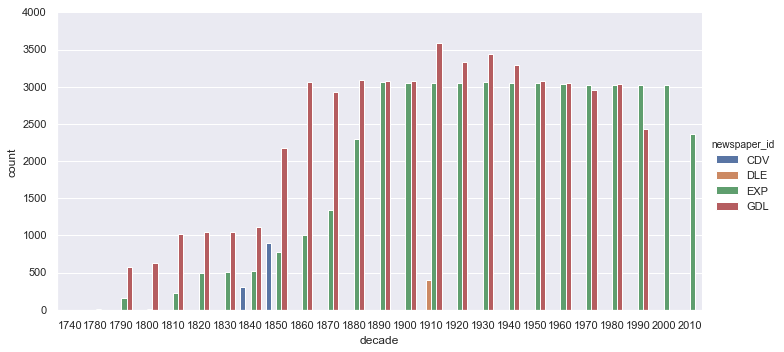

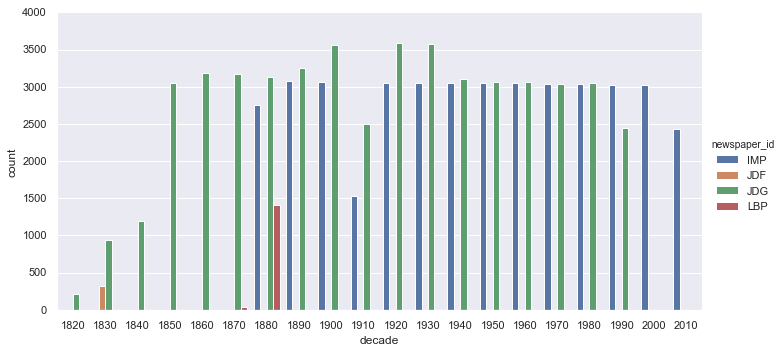

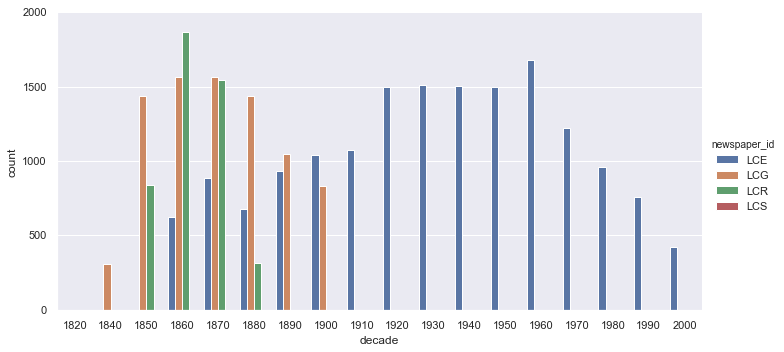

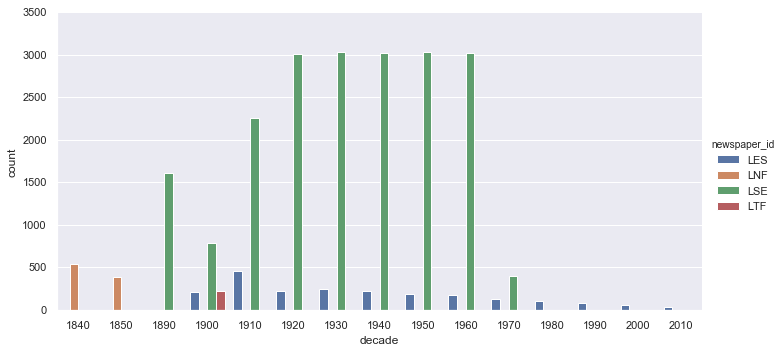

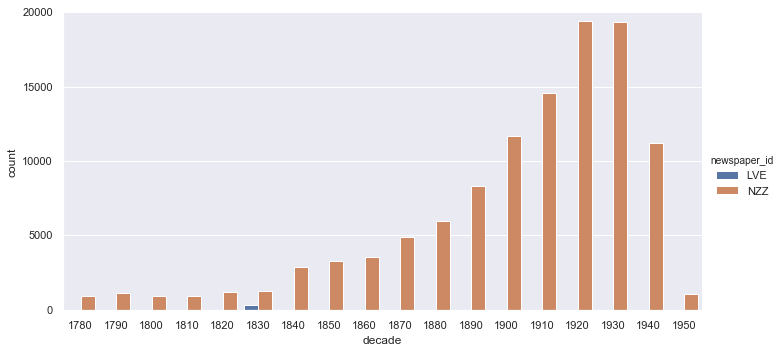

In [9]:
plot_issues_time_id('decade', EARLIEST, LATEST, df = issues_df, country='CH', batch_size=4)

#### Make more intelligent plot groups

In [10]:
# Idea : reorder the np_ids list based on 
# - the number of decades for which the newspaper is represented
# - TODO : try other orders

In [11]:
# get np ids ordered by spread in time (nb of decades in which they are represented)
count_df,_,_ = group_and_count(decade_from_year_df(issues_df), ['decade', 'newspaper_id'], 'id')
ids_ordered = count_df.newspaper_id.value_counts().index

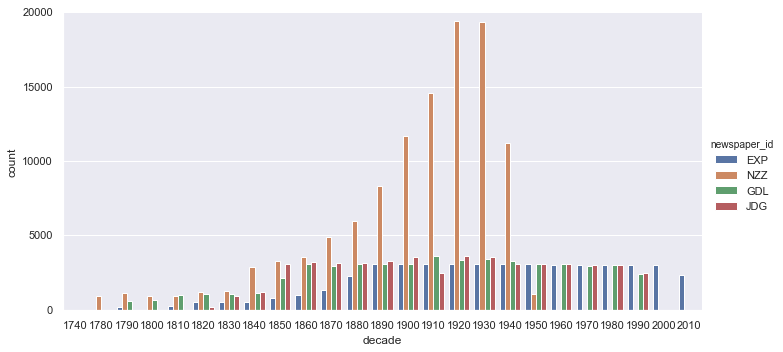

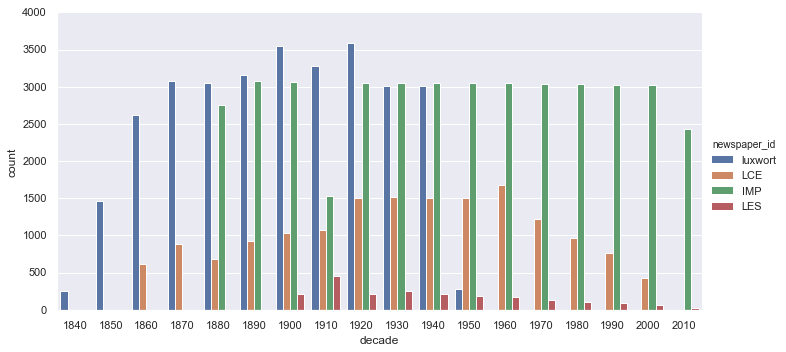

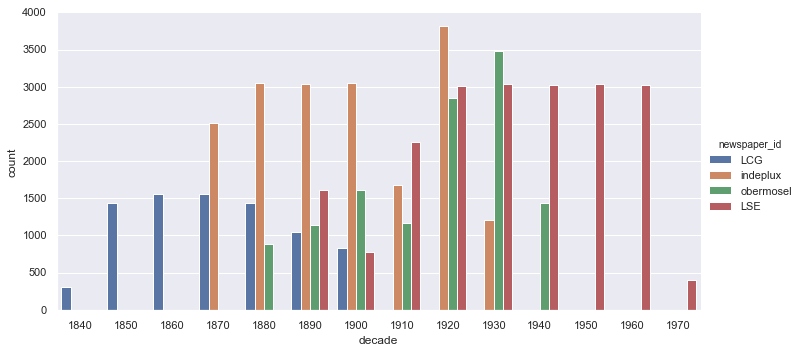

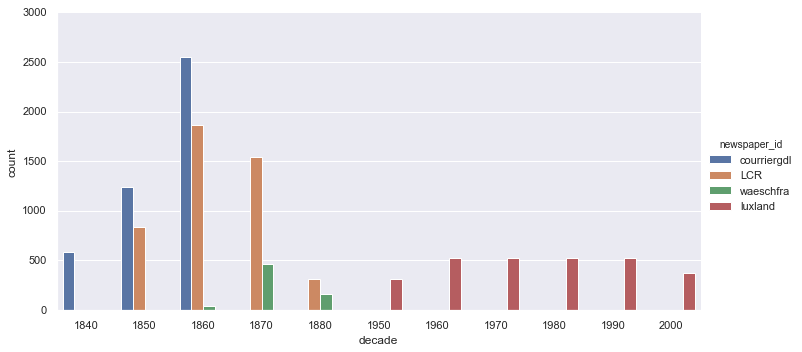

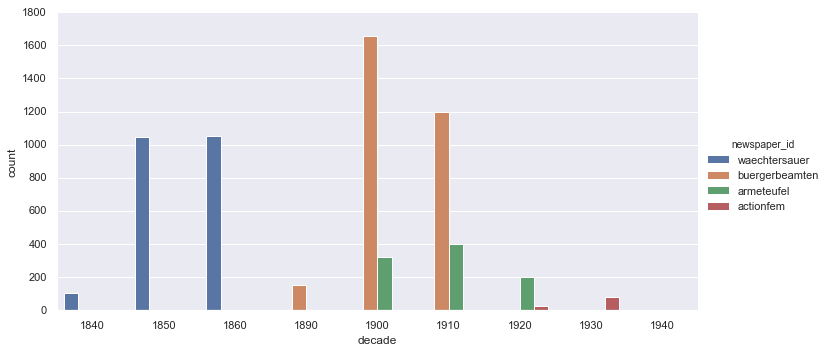

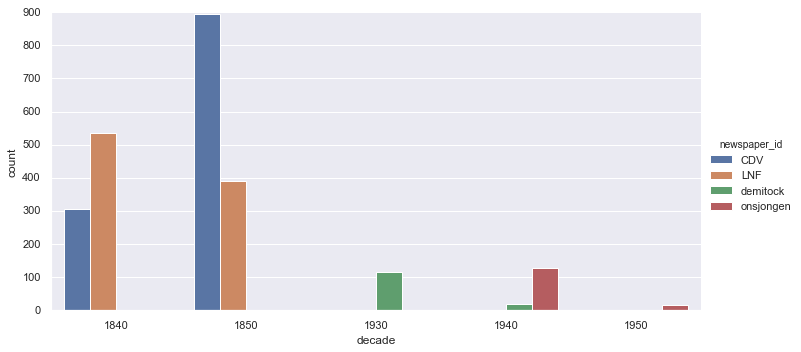

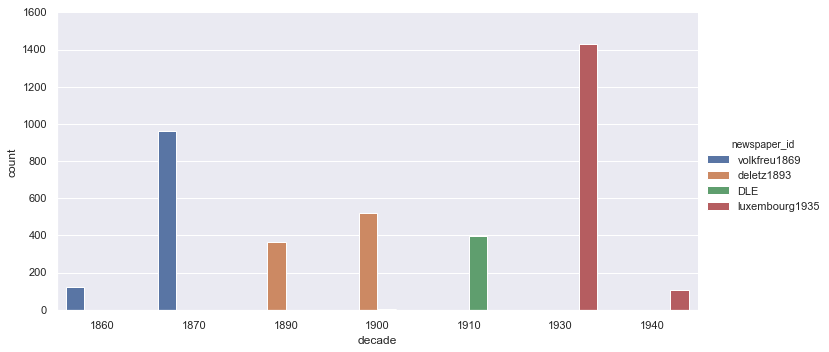

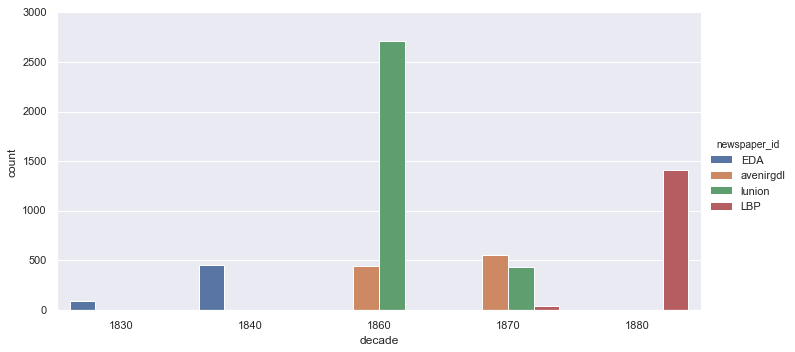

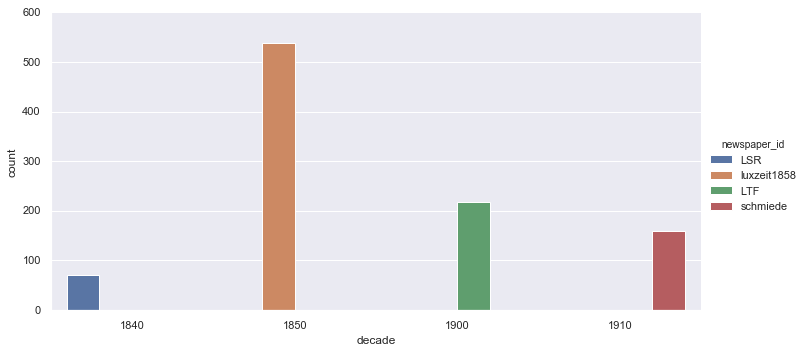

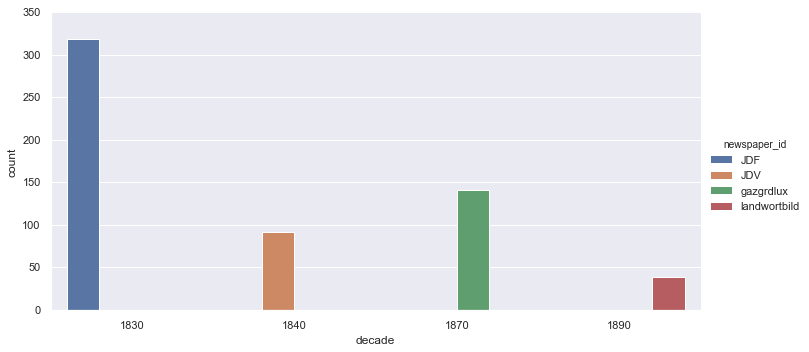

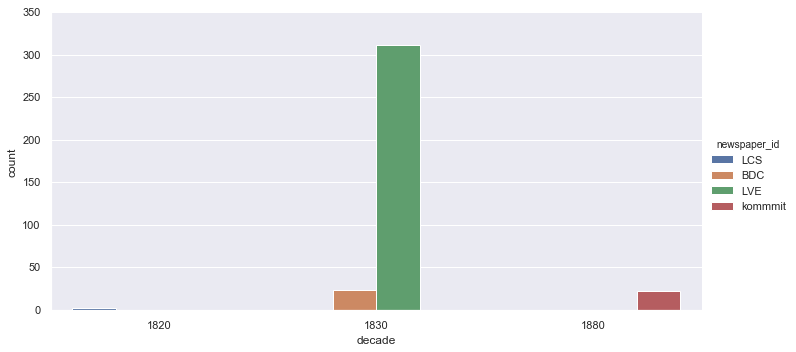

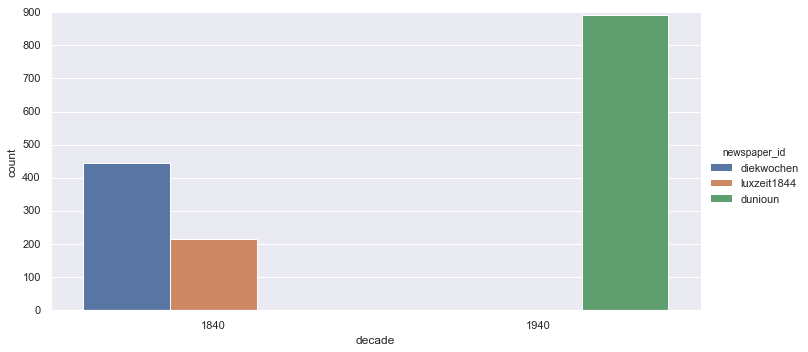

In [16]:
catplot_by_batch_np(count_df, ids_ordered, max_cat=4)

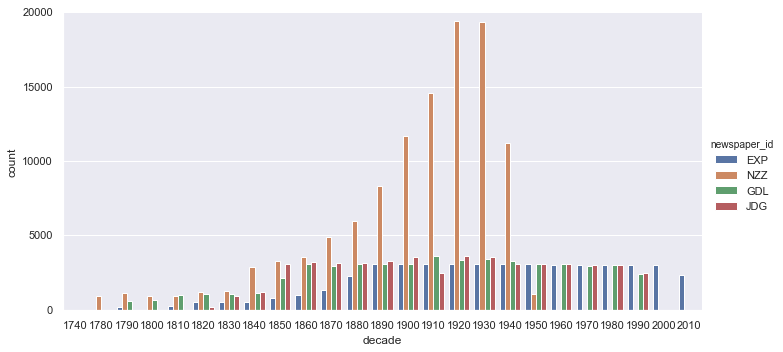

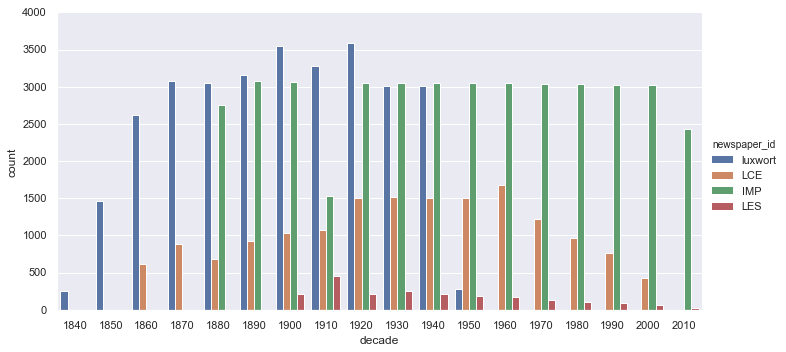

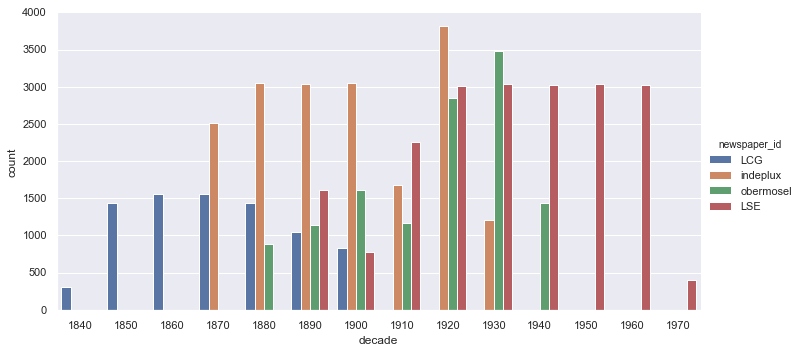

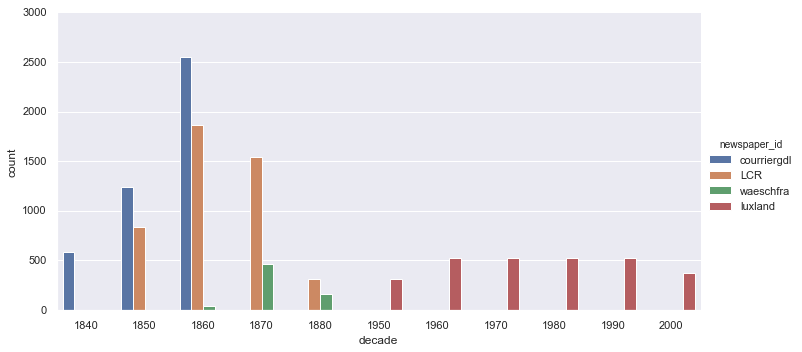

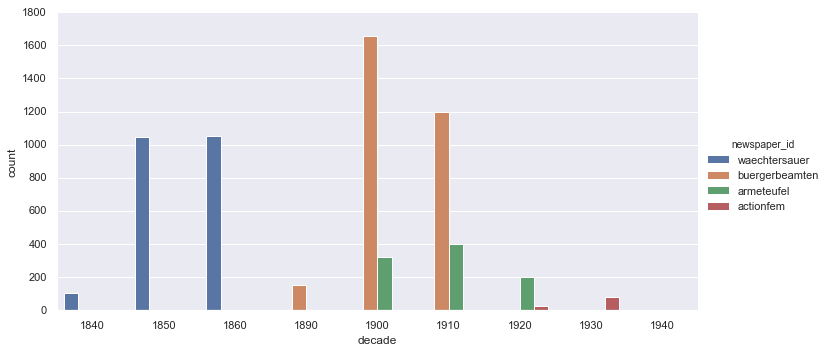

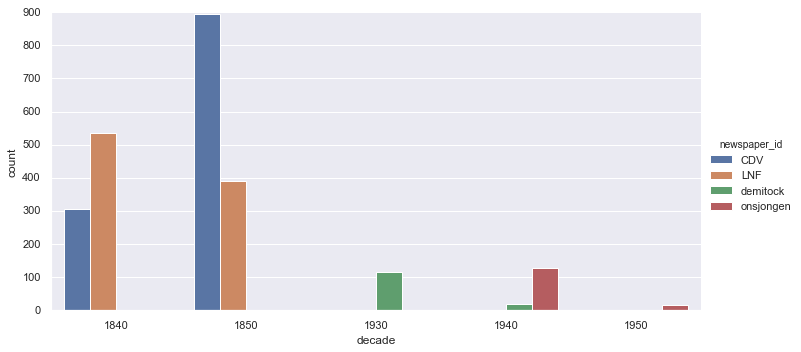

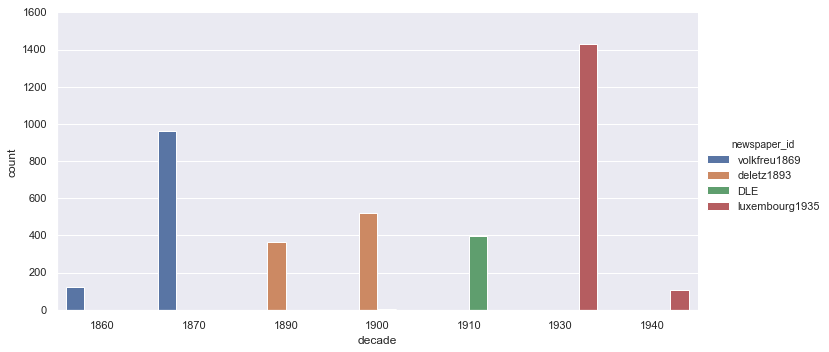

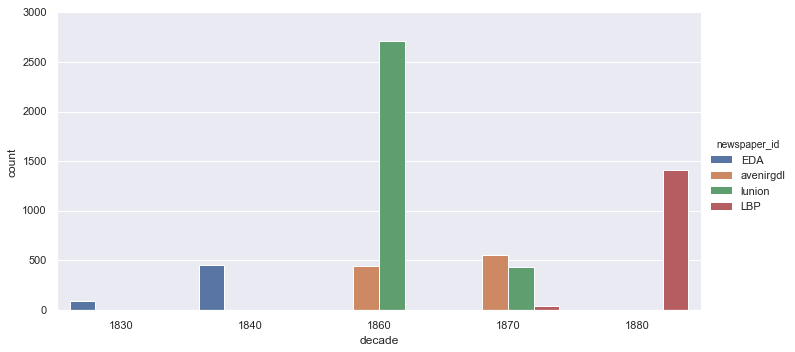

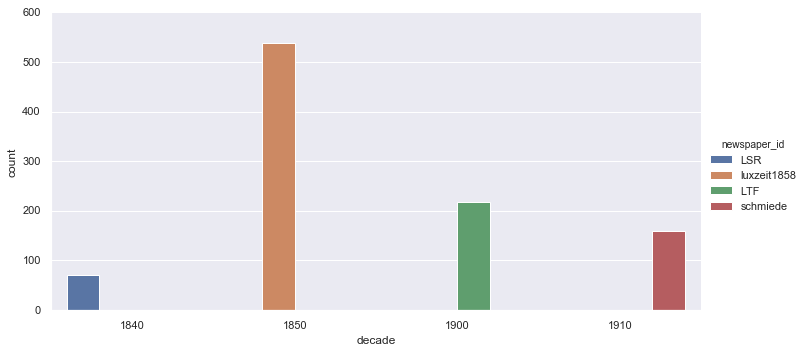

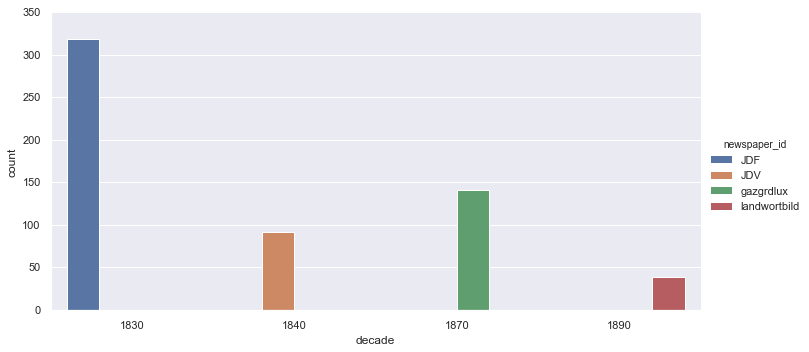

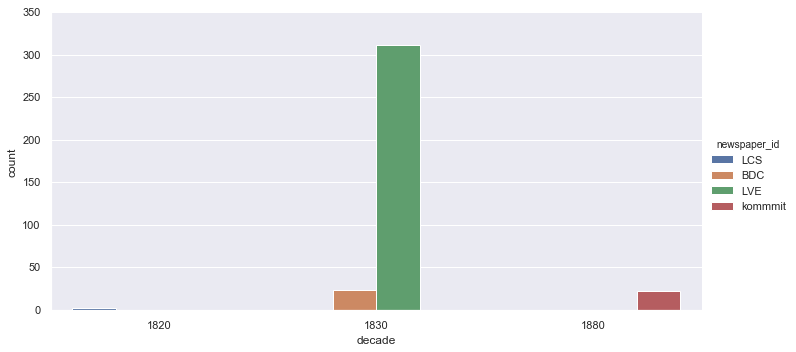

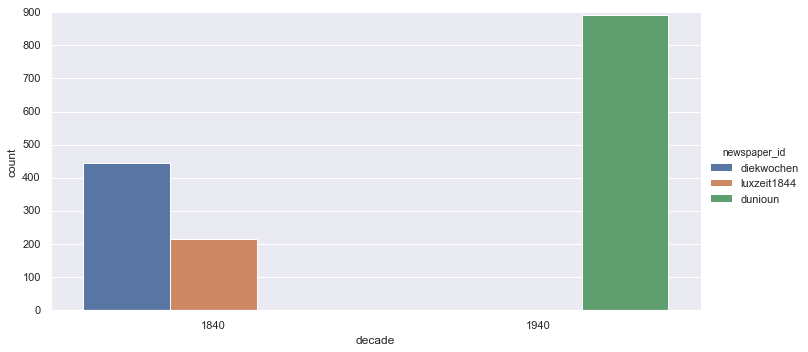

In [15]:
catplot_by_batch_np2(count_df, ids_ordered, 'decade', 'count', 'newspaper_id', max_cat = 4)